In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from src.coordinator import Coordinator
from src.utils.preprocessing import TextPreprocessor
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
coord = Coordinator()

In [8]:
df = pd.read_json(coord.data_interim.joinpath('dataset_v1.jsonl'), lines=True)

In [9]:
df.head(3)

,tweet_id,user,time_epoch,tweet,n_likes,n_retweets,n_replies,n_emojies,hashtags,mentions
0,1247643096596111362,britneyspears,1586296268,Enough said 🧼🧼 and thank you to all of the hea...,86426,25499,960,5,"[#worldhealthday, #thankshealthheroes]",[]
1,1243706495793074182,britneyspears,1585357710,Oops!…how did 20 years go by so fast ?! I can...,122851,16256,2212,8,[],[]
2,1243668424674459648,britneyspears,1585348633,Happy Birthday @MariahCarey !! You are one of ...,61079,7634,1345,1,[],[mariahcarey]


In [10]:
print('Number of tweets with hashtags:', df['hashtags'].apply(lambda hashtags: bool(hashtags)).sum())
print('Number of hashtags:', df['hashtags'].apply(lambda hashtags: len(hashtags)).sum())

Number of tweets with hashtags: 39089
Number of hashtags: 50401


In [11]:
from collections import Counter

In [12]:
hashtags_stat = Counter()
df['hashtags'].apply(lambda hashtags: hashtags_stat.update(hashtags))
print('Number of unique hashtags:', len(hashtags_stat))

Number of unique hashtags: 14225


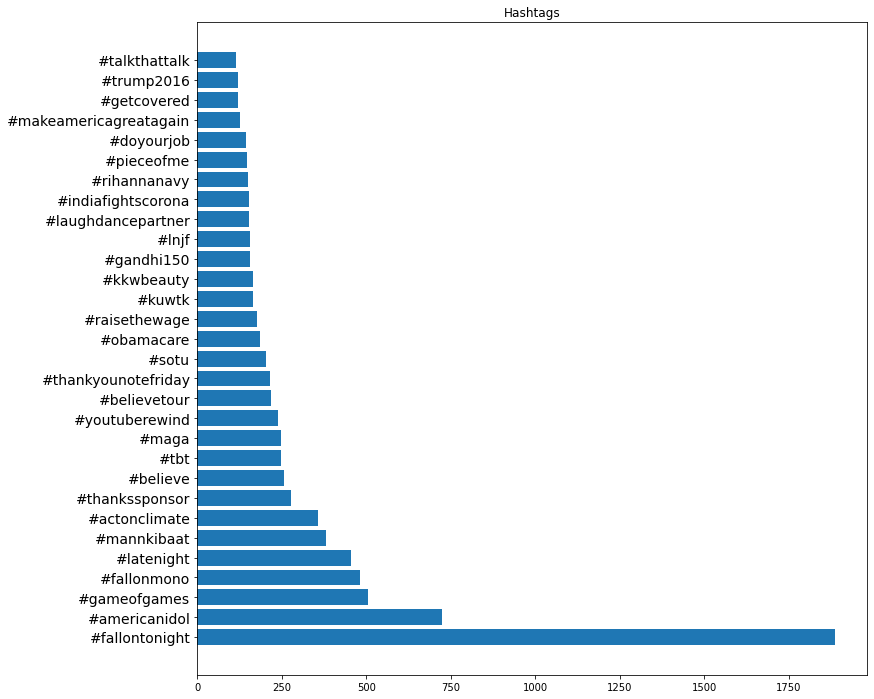

In [13]:
plt.figure(figsize=(12, 12))
plt.barh(*zip(*hashtags_stat.most_common(30)))
plt.yticks(size=14);
plt.title('Hashtags');

# Statisitcs by user

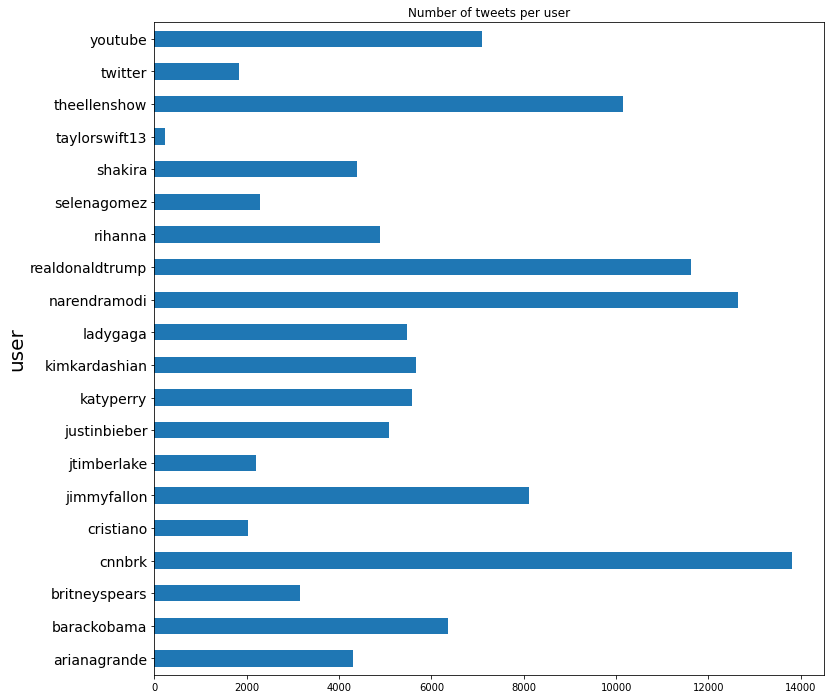

In [14]:
plt.figure(figsize=(12, 12))
df.groupby('user').size().plot(kind='barh');
plt.yticks(size=14);
plt.ylabel('user', size=20);
plt.title('Number of tweets per user');

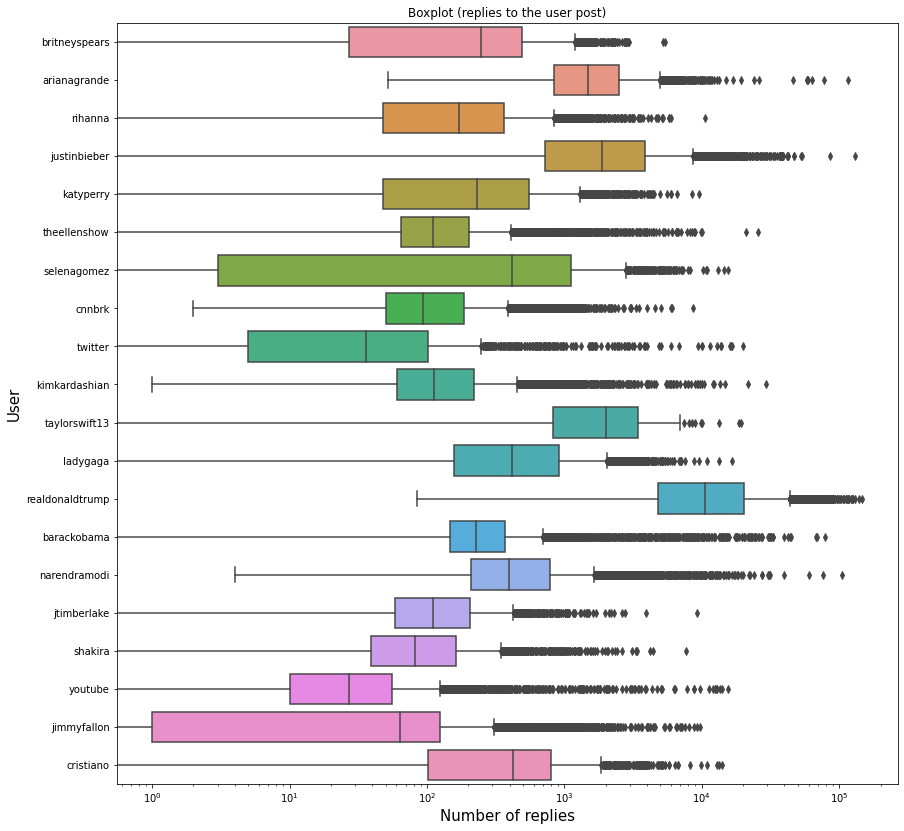

In [15]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_replies", y="user", data=df);
plt.ylabel('User', size=15);
plt.xlabel('Number of replies', size=15);
plt.title("Boxplot (replies to the user post)");

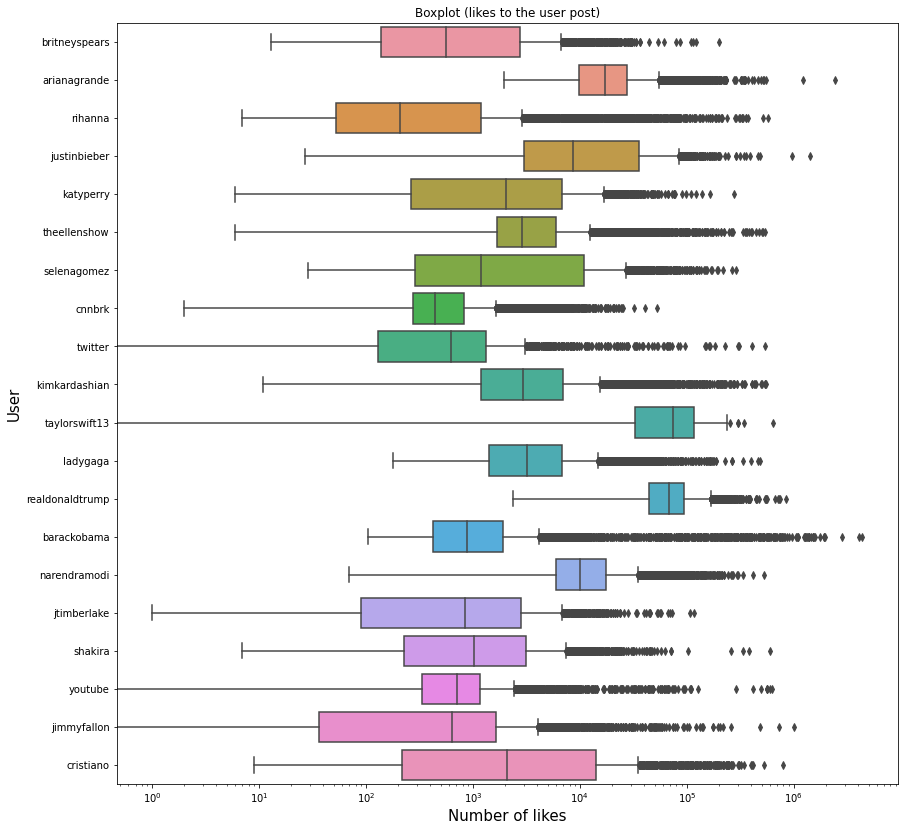

In [16]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_likes", y="user", data=df);
plt.ylabel('User', size=15);
plt.xlabel('Number of likes', size=15);
plt.title("Boxplot (likes to the user post)");

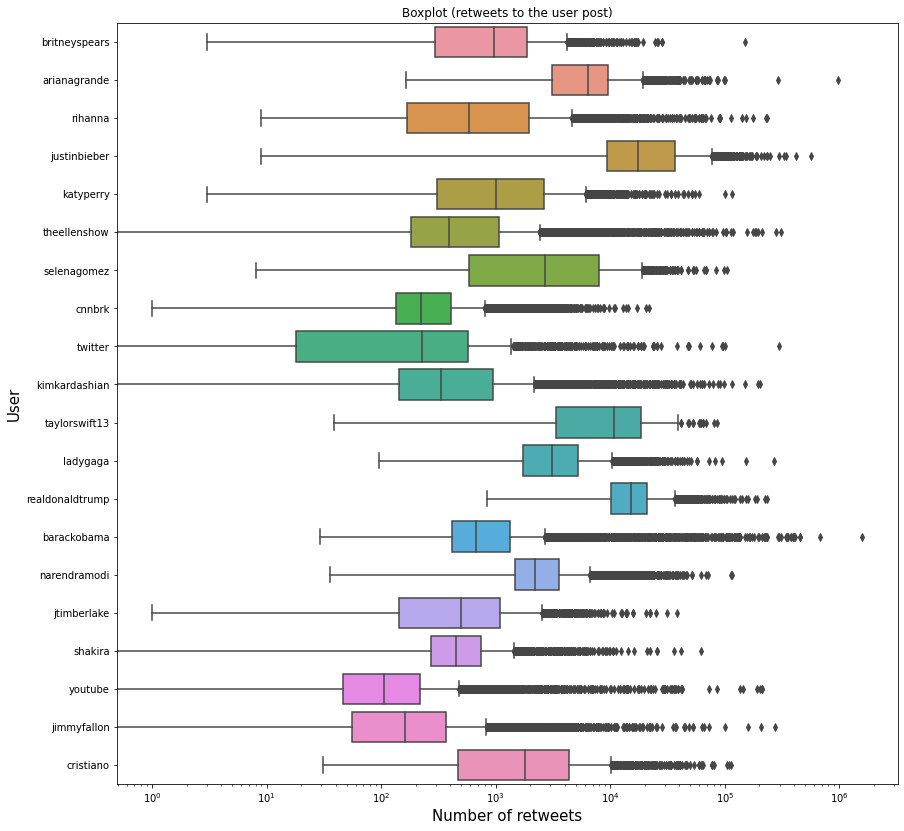

In [17]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_retweets", y="user", data=df);
plt.ylabel('User', size=15);
plt.xlabel('Number of retweets', size=15);
plt.title("Boxplot (retweets to the user post)");

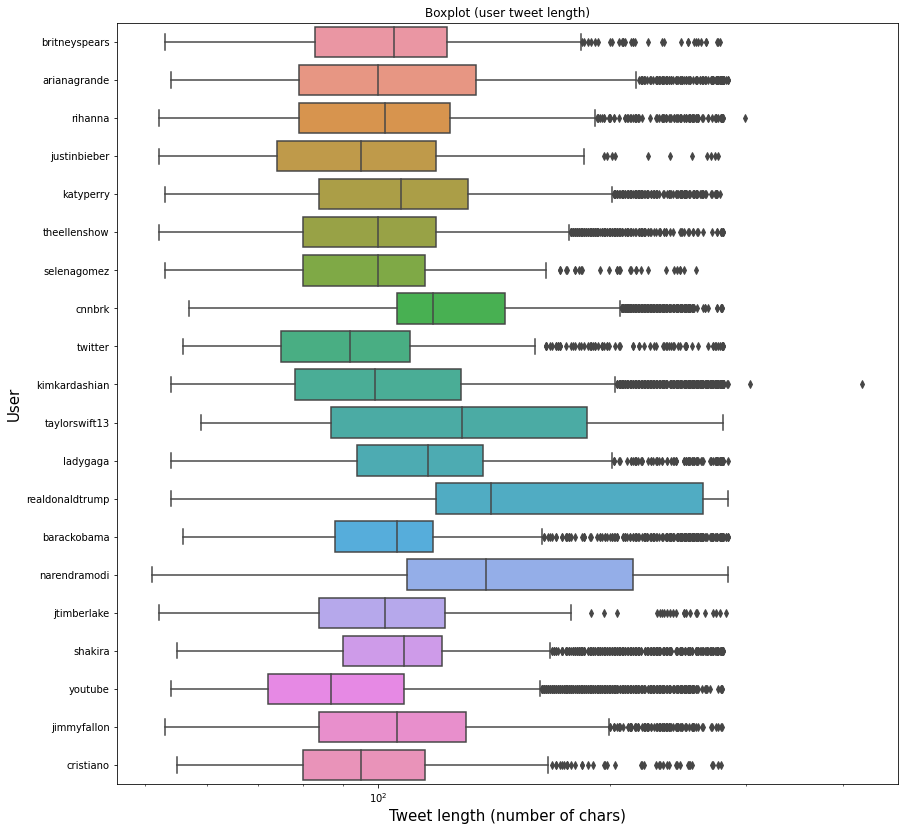

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x=df['tweet'].apply(lambda tweet: len(tweet)), y="user", data=df);
plt.ylabel('User', size=15);
plt.xlabel('Tweet length (number of chars)', size=15);
plt.title("Boxplot (user tweet length)");

# Statistics by account type
**Let's divide users by their account types**

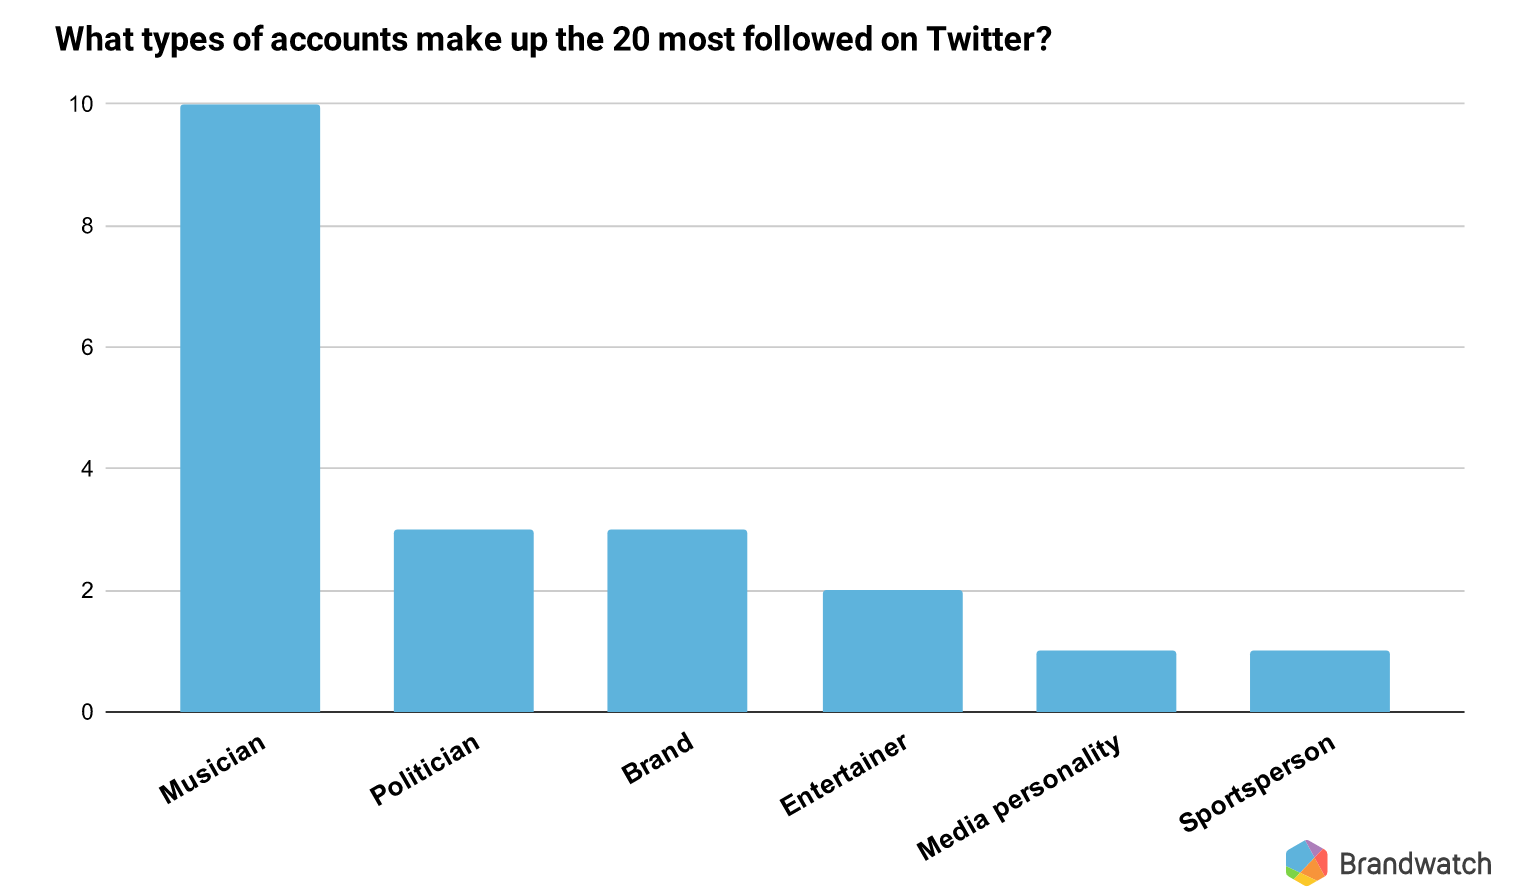

In [19]:
user_types = {'musicians': ['taylorswift13', 'shakira', 'selenagomez', 'rihanna', 'katyperry', 'justinbieber', 'jtimberlake', 'britneyspears', 
                            'arianagrande', 'ladygaga'], 
             'politician': ['realdonaldtrump', 'narendramodi', 'barackobama'],
             'brand': ['youtube', 'twitter', 'cnnbrk'], 
             'entertainer': ['jimmyfallon', 'theellenshow'],
             'media_personality': ['kimkardashian'],  
             'sportsperson': ['cristiano']}

def get_user_type(user):
    for user_type in user_types:
        if user in user_types[user_type]:
            return user_type

df['user_type'] = df['user'].apply(get_user_type)

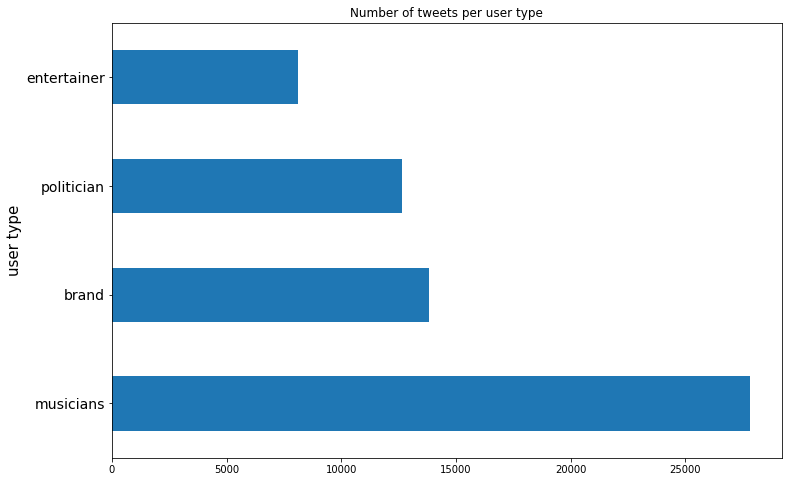

In [20]:
plt.figure(figsize=(12, 8))
df['user_type'].value_counts().plot(kind='barh');
plt.yticks(size=14);
plt.ylabel('user type', size=15);
plt.title('Number of tweets per user type');

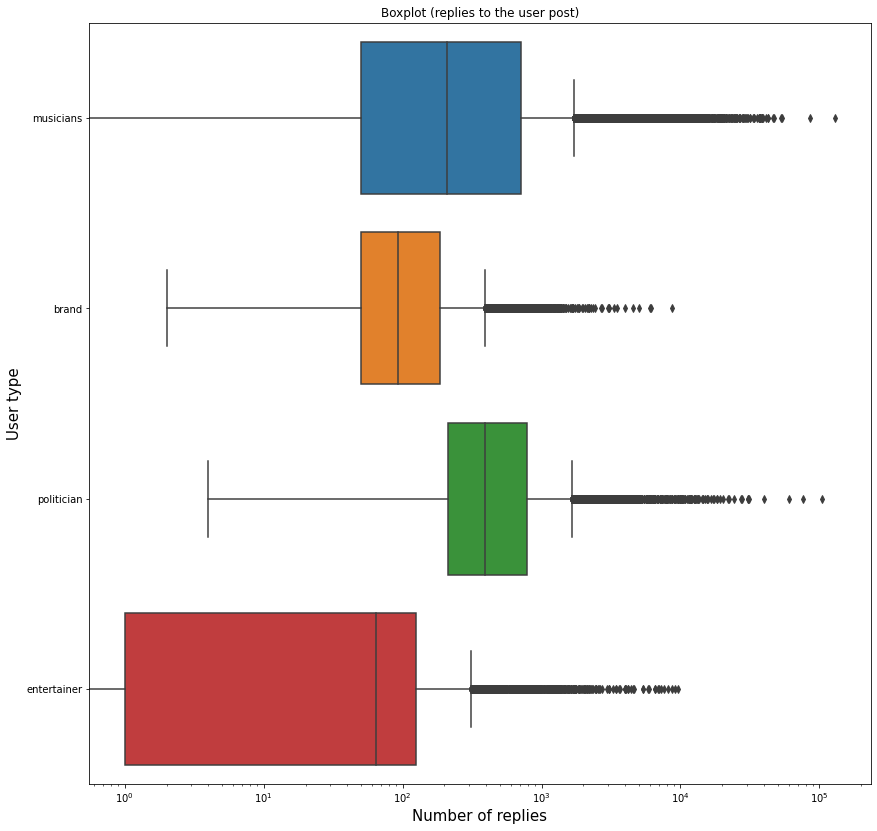

In [27]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_replies", y="user_type", data=df);
plt.ylabel('User type', size=15);
plt.xlabel('Number of replies', size=15);
plt.title("Boxplot (replies to the user post)");

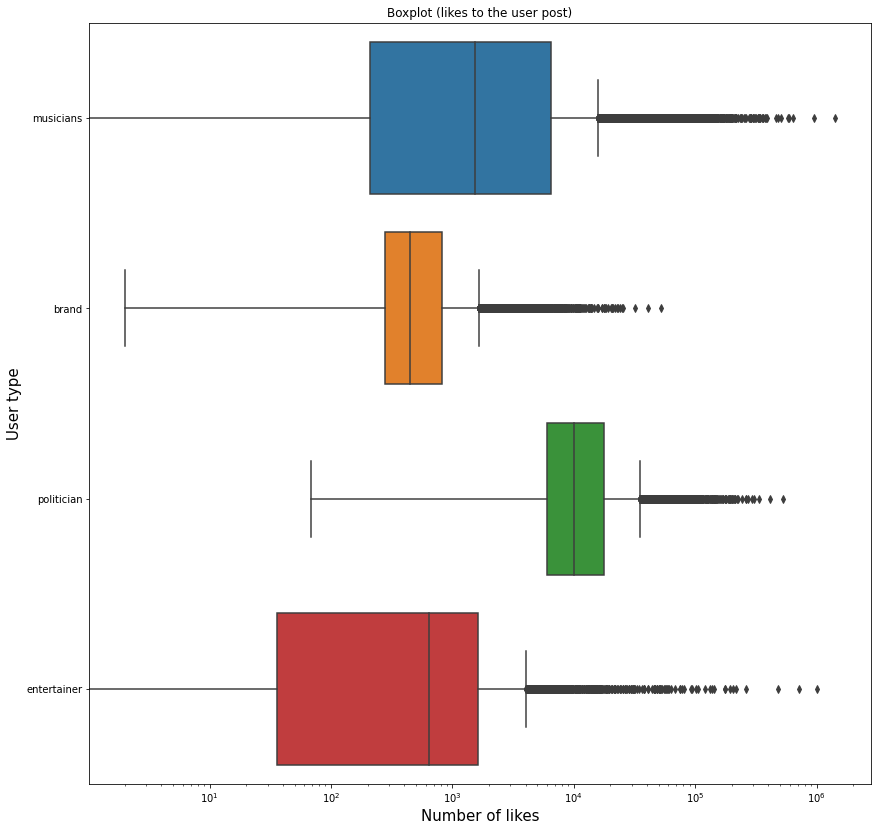

In [28]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_likes", y="user_type", data=df);
plt.ylabel('User type', size=15);
plt.xlabel('Number of likes', size=15);
plt.title("Boxplot (likes to the user post)");

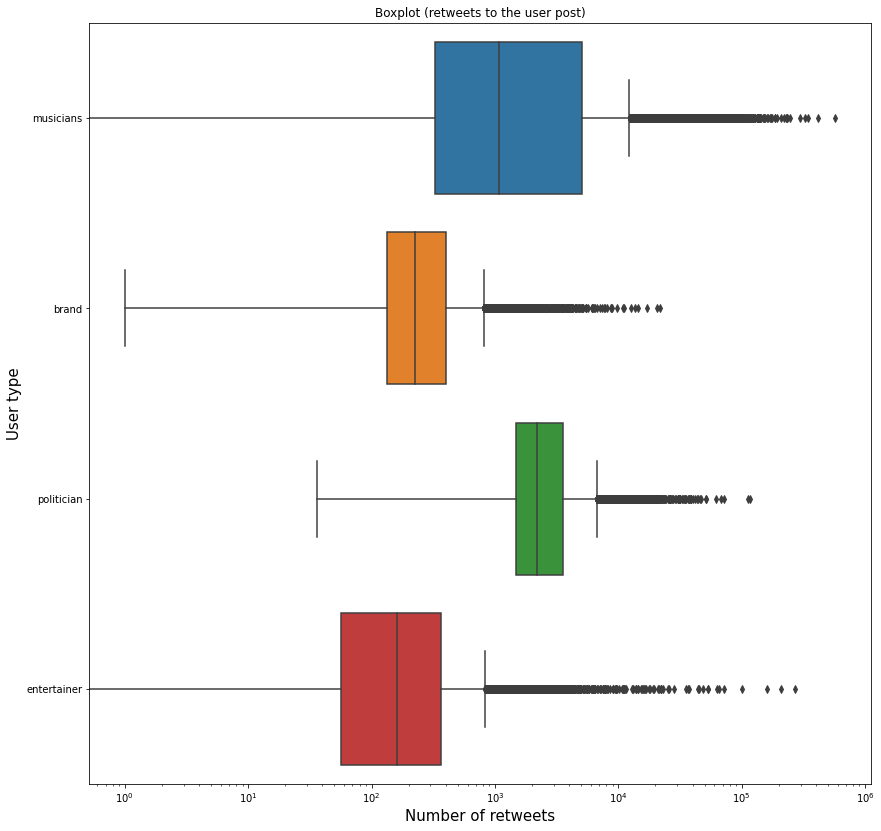

In [29]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x="n_retweets", y="user_type", data=df);
plt.ylabel('User type', size=15);
plt.xlabel('Number of retweets', size=15);
plt.title("Boxplot (retweets to the user post)");

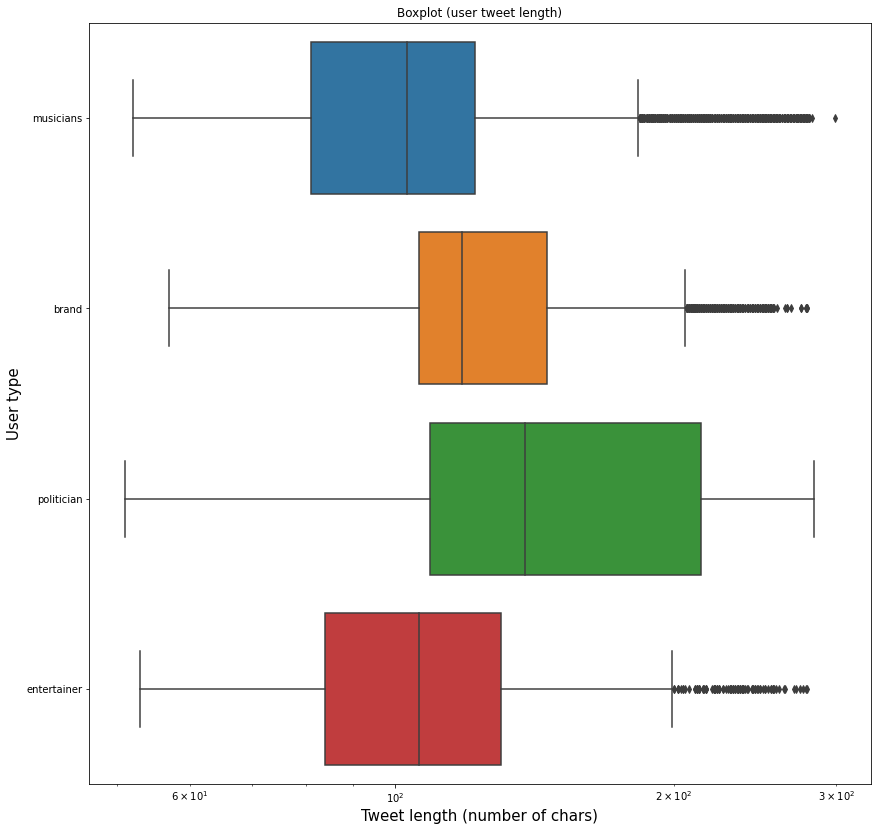

In [30]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xscale("log")
sns.boxplot(x=df['tweet'].apply(lambda tweet: len(tweet)), y="user_type", data=df);
plt.ylabel('User type', size=15);
plt.xlabel('Tweet length (number of chars)', size=15);
plt.title("Boxplot (user tweet length)");

# N-gram analysis
We will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets.

In [21]:
preprocessor = TextPreprocessor(lowercase=True, clean_links=True, clean_punctuation=True, expand_contractions=True, remove_stop_words=True, 
                                process_numbers='remove', normalization_type='lemma',
                                clean_mentions=True, clean_emojis=True)

In [26]:
from tqdm import tqdm
tqdm.pandas()

df['tokenized_tweet'] = df['tweet'].progress_apply(preprocessor)

100%|██████████| 116875/116875 [19:20<00:00, 100.70it/s]


In [33]:
df.to_json(coord.data_processed / 'processed_dataset_v1.jsonl', lines=True, orient='records')

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), lowercase=False, tokenizer=lambda tokens: tokens).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Bigrams over full corpus

### Full corpus

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2319 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/pytho

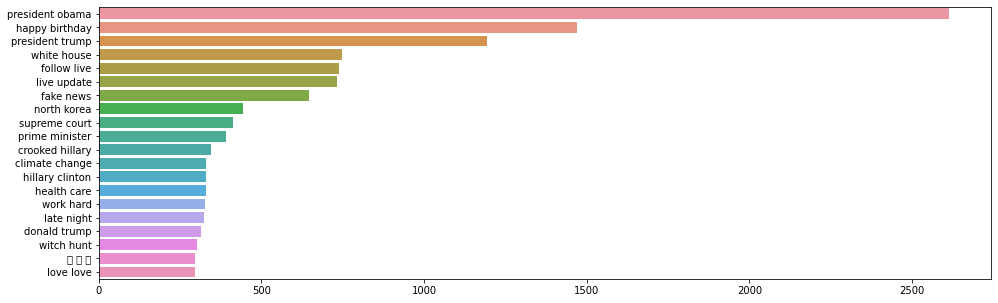

In [38]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

### Musicians

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


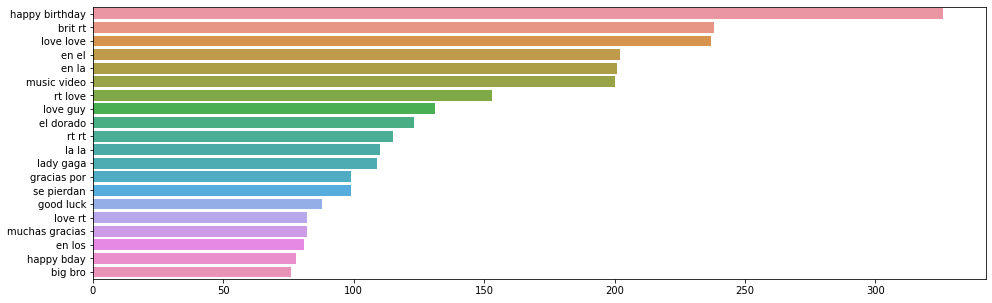

In [42]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['user_type'] == 'musicians']['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

### Brand

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


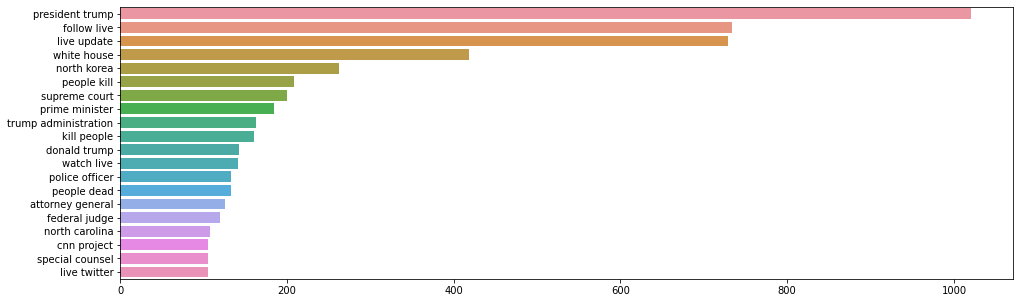

In [44]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['user_type'] == 'brand']['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

### Media personality

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


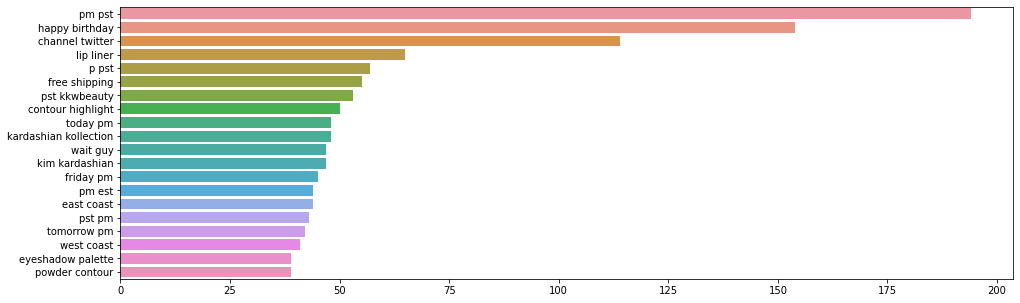

In [45]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['user_type'] == 'media_personality']['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

### Politician

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 2319 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/pytho

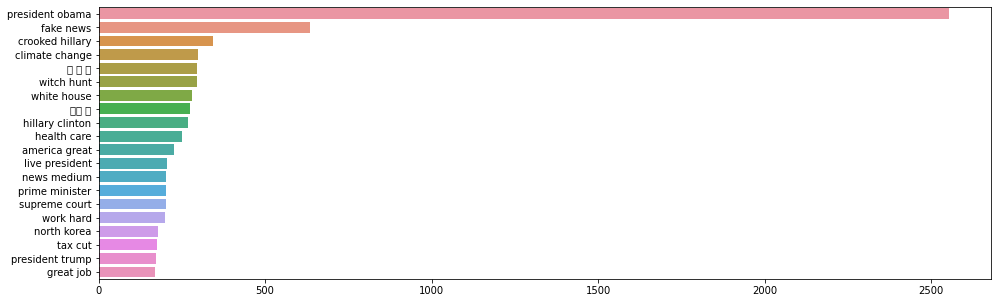

In [46]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['user_type'] == 'politician']['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

### Sportsperson

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


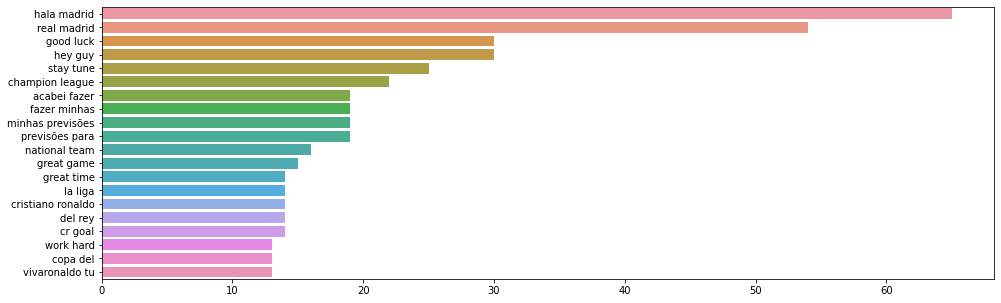

In [47]:
plt.figure(figsize=(16,5))
top_tweet_bigrams = get_top_tweet_bigrams(df[df['user_type'] == 'sportsperson']['tokenized_tweet'])[:20]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x);

## Wordcloud

### Full corpus

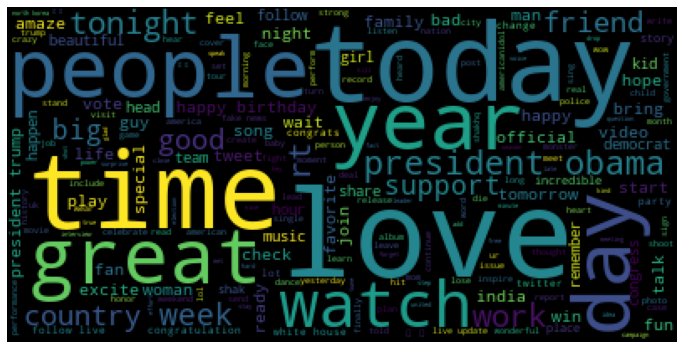

In [50]:
from wordcloud import WordCloud

plt.figure(figsize=(12,8))

tokens = []
df['tokenized_tweet'].apply(lambda toks: tokens.extend(toks));
word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Musicians

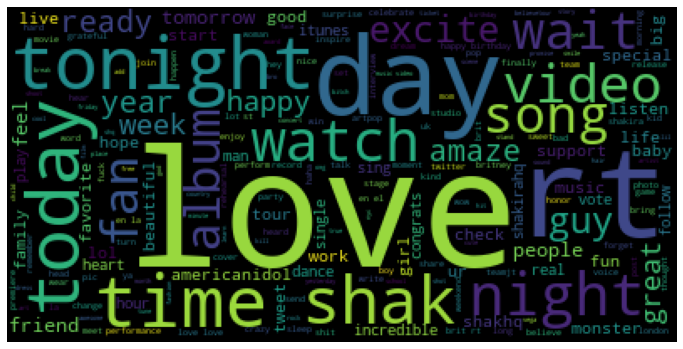

In [52]:
def get_tokens(df, user_type):
    tokens = []
    df[df['user_type'] == user_type]['tokenized_tweet'].apply(lambda toks: tokens.extend(toks))
    return tokens
    
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'musicians')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Entertainer

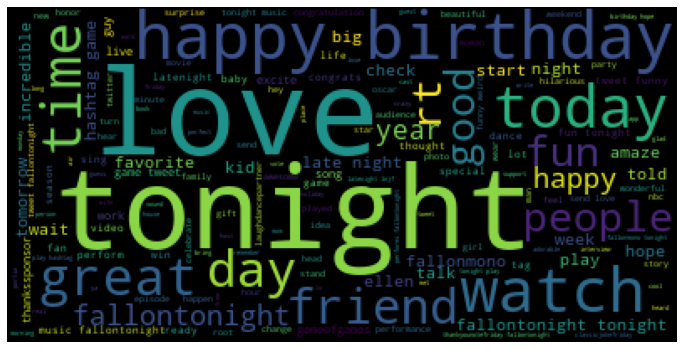

In [53]:
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'entertainer')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Brand

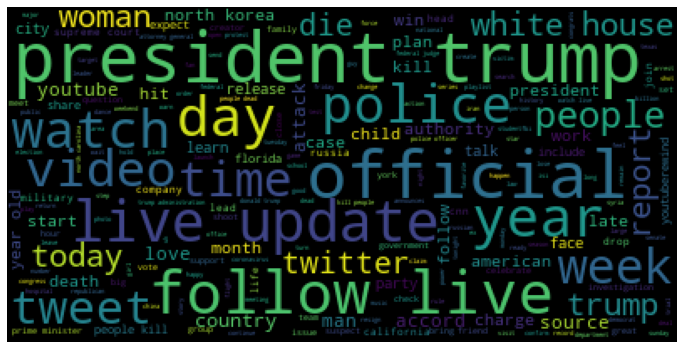

In [54]:
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'brand')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Media personality

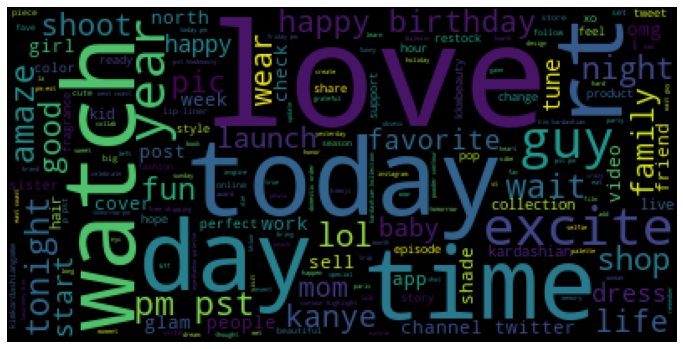

In [55]:
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'media_personality')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Politician

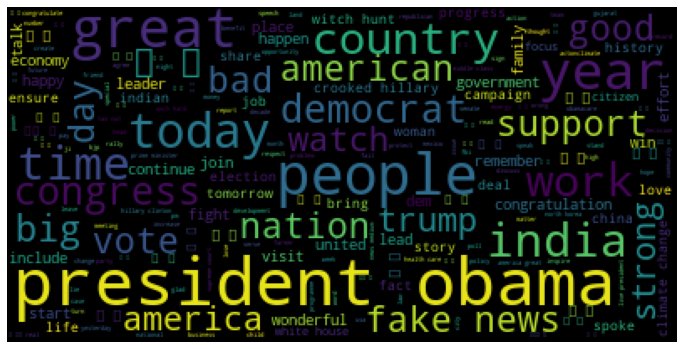

In [56]:
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'politician')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();

### Sportsperson

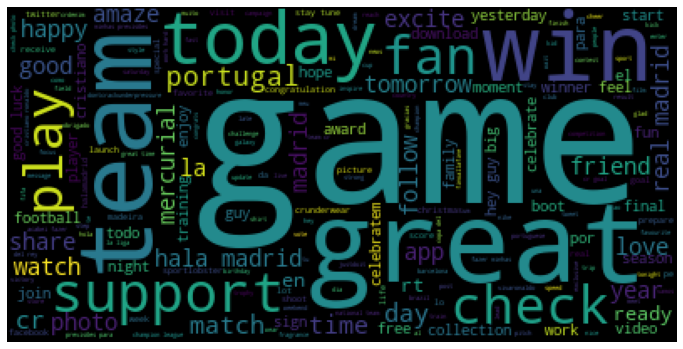

In [57]:
plt.figure(figsize=(12,8))

tokens = get_tokens(df, 'sportsperson')

word_cloud = WordCloud().generate(" ".join(tokens))
plt.imshow(word_cloud)
plt.axis('off')
plt.show();